In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import importlib

import agps_config
importlib.reload(agps_config)
from agps_config import DEFAULT_STARTUP_TIME, DEFAULT_WARMUP_TIME, DEFAULT_SFC_AGPS, DEFAULT_SPEED_AGPS, DISTANCE_MATRIX, DEFAULT_BUFFER_AGPS

In [2]:
# Some layout settings for the plots
fontsize_ticks = 14
fontsize_xylabels = 16
fontsize_title = 16

# Color settings for plots
cmap = plt.colormaps['tab20']
colors = [cmap(i) for i in range(8)]

In [3]:
import agps_optim
importlib.reload(agps_optim)

from agps_optim import get_df_movements

# Load df_movements from pickle file
df_movements = get_df_movements('LSZH_MAY_SEP_df_movements.pkl')


### Fuel Consumption during Normal Taxi & AGPS-assisted Taxi

![Taxi Modes Fuel Consumption](ATRS_taxi.jpg)

In [4]:
# Calculate Taxi Fuel Consumption (Normal and AGPS-assisted)


import agps_optim
importlib.reload(agps_optim)
from agps_optim import calculate_normal_taxi_fuel, calculate_agps_taxi_fuel

df_movements = calculate_normal_taxi_fuel(df_movements=df_movements,
                                            startupTime=DEFAULT_STARTUP_TIME, # In Seconds
                                            warmupTime=DEFAULT_WARMUP_TIME, # In Seconds
                                            sfc_agps=DEFAULT_SFC_AGPS) # Specific fuel consumption of tug (kg/s)


df_movements = calculate_agps_taxi_fuel(df_movements=df_movements,
                                            startupTime=DEFAULT_STARTUP_TIME, # In Seconds
                                            warmupTime=DEFAULT_WARMUP_TIME, # In Seconds
                                            sfc_agps=DEFAULT_SFC_AGPS) # Specific fuel consumption of tug (kg/s)


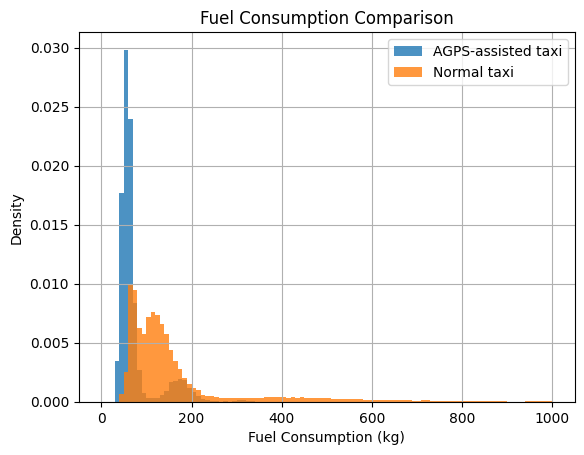

In [5]:
df_movements['F_i_agps'].hist(bins=100, range=(0, 1000), label='AGPS-assisted taxi', density=True, alpha=0.8)
df_movements['F_i_norm'].hist(bins=100, range=(0, 1000), label='Normal taxi', density=True, alpha=0.8)

plt.xlabel('Fuel Consumption (kg)')
plt.ylabel('Density')
plt.legend()
plt.title('Fuel Consumption Comparison')
plt.grid(True)
plt.show()

***
# Optimization Model
***

**Tug allocation rule:** 
* Dedication
* Common-use


**Tug dispatch strategy**
1. FCFS
2. Only large, only small A/C
3. Consider only aircraft from certain stand areas
4. Consider only "simple" tug movements (meaning no runway crossings)


**Stuff to be fixed / improved:**
* Tug must consume fuel on turnaround as well
* Turnaround time cannot be fixed but rather depends on distance travelled by the tug
* Add buffer time for attachment and detatchment of tug
* If stand_area unknown, check if parking_position

***
# Fuel Reduction = f(nTugs)
***

In [59]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import importlib
import agps_optim

# Reload the module to pick up changes
importlib.reload(agps_optim)

from agps_optim import optimize_day

ImportError: cannot import name 'optimize_day' from 'agps_optim' (/Users/wate/Documents/GitHub/osn24_agps/agps_optim.py)

In [ ]:
# Specific fuel consumption of conventional pushback tug: 22.7l/h --> 19.3kg/h (sfc value is from Postorino et al. 2019)
sfc_tug = 20  # kg/h

# Calculate tug fuel consumption per flight (kg)
df_movements['extAGPStug'] = (df_movements['taxiDuration'].dt.total_seconds()/3600) * sfc_tug


df_movements['date'] = df_movements['lineupTime'].dt.date

In [7]:
def run_optimization_for_tugs(
    n_tugs,
    df_filtered,
    num_workers,
    allowed_aircraft_types,
    allowed_combinations,
    T_turn,
    solver_method
):
    results = []
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {
            executor.submit(
                optimize_day,
                date,
                subset_df,
                n_tugs,
                T_turn,
                solver_method,
                allowed_aircraft_types,
                allowed_combinations
            ): date
            for date, subset_df in df_filtered.groupby('date')
        }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"n_tugs = {n_tugs}"):
            try:
                result = future.result()
                if not result.empty:
                    results.append(result)
            except Exception as e:
                print(f"Error processing a day's optimization: {e}")
    
    # Combine results into a single DataFrame for the current n_tugs
    if results:
        df_results = pd.concat(results, ignore_index=True)
        df_results['n_tugs'] = n_tugs  # Add column to track the number of tugs used for each run
        return df_results
    else:
        return pd.DataFrame()

In [ ]:
# All Aircrafttypes, All Stand-Runway Combinations Allowed
config_1 = {
    'name': 'allTypes_allCombinations',
    'allowed_aircraft_types': [],
    'allowed_combinations': []
}

# Narrow Body Aircraft only, All Stand-Runway Combinations Allowed
config_2 = {
    'name': 'Narrow_Bodys_allCombinations',
    'allowed_aircraft_types': ['A320', 'A321', 'A20N','A21N','A319', 
                          'BCS1', 'BCS3', 
                          'B733', 'B734', 'B735', 'B736', 'B737', 'B738', 'B739', 'B38M', 'B39M',
                          'E190','E195', 'E295', 'E75L', 'E75S'],
    'allowed_combinations': []  # No restriction, all combinations allowed
}

# All Aircraft Types, only Stand-Runway combination without runway crossings
config_3 = {
    'name': 'no_runway_crossings',
    'allowed_aircraft_types': [],
    'allowed_combinations': [('A North', '28'),
                             ('A North', '34'),
                             ('AB Courtyard', '28'),
                             ('AB Courtyard', '34'),
                             ('B South', '28'),
                             ('B South', '34'),
                             ('C', '28'),
                             ('C', '34'),
                             ('D', '28'),
                             ('D', '34'),
                             ('G', '28'),
                             ('G', '34'),
                             ('T', '28'),
                             ('T', '34'),
                             ('I', '28'),
                             ('I', '34'),
                             ('F', '28'),
                             ('F', '34'),
                             ('GAC', '28'),
                             ('GAC', '34'),
                             ('E', '32'),
                             ('E', '16')
                             ]
}


# List of configurations to test
configs = [config_1]

# Store results in a dictionary where keys are configuration names
results_dict = {}

# Run the optimization for different numbers of tugs (0 to 20)
tug_counts = list(range(0, 21))
num_workers = 10
T_turn = 15  # Turnaround time in minutes
solver_method = "highs"  # Use the efficient 'highs' solver

for config in configs:
    config_name = config['name']
    results_dict[config_name] = {}

    print(f"Running configuration: {config_name}")

    for n_tugs in tug_counts:
        #print(f"Running optimization for: {config_name}, n_tugs = {n_tugs}")
        
        df_tugs_results = run_optimization_for_tugs(
            n_tugs,
            df_movements,
            num_workers,
            config['allowed_aircraft_types'],
            config['allowed_combinations'],
            T_turn,
            solver_method
        )
        
        results_dict[config_name][n_tugs] = df_tugs_results  # Store results in dictionary
    

Running configuration: allTypes_allCombinations


n_tugs = 20: 100%|██████████| 153/153 [00:03<00:00, 41.04it/s]


Running configuration: Narrow_Bodys_allCombinations


n_tugs = 20: 100%|██████████| 153/153 [00:03<00:00, 45.24it/s]

Running configuration: no_runway_crossings



n_tugs = 20: 100%|██████████| 153/153 [00:03<00:00, 42.87it/s]


In [17]:
addOSN24_data = True

# Create a list to collect the data for the final DataFrame
df_results_list = []

# Iterate through each configuration name in results_dict
for config_name, config_results in results_dict.items():
    for n_tugs, df_tugs_results in config_results.items():
        if not isinstance(df_tugs_results, pd.DataFrame) or df_tugs_results.empty:
            continue  # Skip if there is no data for the specific n_tugs
        
        # Calculate fuel_AGPS for the current DataFrame
        fuel_AGPS = (
            df_tugs_results['Adjusted_Fuel_Consumption'].sum() +
            df_tugs_results['MESengine'].sum() +
            df_tugs_results['MESapu'].sum()
        )

        # Calculate baseline for the current DataFrame
        baseline = (
            df_tugs_results['MESengine'].sum() +
            df_tugs_results['MESapu'].sum() +
            df_tugs_results['normTAXIengine'].sum()
        )

        # Append the result as a dictionary to the list
        df_results_list.append({
            'config_name': config_name,
            'nTugs': n_tugs,
            'baseline': baseline,
            'AGPS_optim': fuel_AGPS,
        })

# Convert the list to a DataFrame
df_results = pd.DataFrame(df_results_list)

if addOSN24_data:
    # Read OSN24 Legacy Results
    df_OSN24_results = pd.read_pickle('fuel_vs_nTugs_OSN24.pkl')

    # Merge for each configuration separately
    df_results = pd.merge(
        df_results,
        df_OSN24_results[['nTugs', 'AGPS_rwy_all']],
        on='nTugs',
        how='left'
    )

    df_results.rename(columns={'AGPS_rwy_all': 'AGPS_OSN24'}, inplace=True)
    df_results['AGPS_OSN24'] = df_results['AGPS_OSN24'] * 1000  # Scale if necessary

df_results

,config_name,nTugs,baseline,AGPS_optim,AGPS_OSN24
0,allTypes_allCombinations,0,8.851565e+06,8.851565e+06,8.851565e+06
1,allTypes_allCombinations,1,8.851565e+06,8.067554e+06,7.750379e+06
2,allTypes_allCombinations,2,8.851565e+06,7.485958e+06,6.941953e+06
3,allTypes_allCombinations,3,8.851565e+06,7.010640e+06,6.308183e+06
4,allTypes_allCombinations,4,8.851565e+06,6.612704e+06,5.768885e+06
...,...,...,...,...,...
58,no_runway_crossings,16,8.851565e+06,5.871213e+06,3.696792e+06
59,no_runway_crossings,17,8.851565e+06,5.845522e+06,3.685156e+06
60,no_runway_crossings,18,8.851565e+06,5.824906e+06,3.678366e+06
61,no_runway_crossings,19,8.851565e+06,5.808561e+06,3.675096e+06


***
# MILP
***

### Definition of Policies

In [6]:
# All Aircrafttypes, All Stand-Runway Combinations Allowed
config_0 = {
    'name': 'All Turbojets',
    'allowed_airlines': [],
    'allowed_aircraft_types': [],
    'allowed_stand_rwy_combinations': [],
    'allowed_time_windows': [],
}

# Narrow Body Aircraft only, All Stand-Runway Combinations Allowed
config_1 = {
    'name': 'Narrow-body only',
    'allowed_airlines': [],
    'allowed_aircraft_types': ['A320', 'A321', 'A20N','A21N','A319', 
                          'BCS1', 'BCS3', 
                          'B733', 'B734', 'B735', 'B736', 'B737', 'B738', 'B739', 'B38M', 'B39M',
                          'E190','E195', 'E295', 'E75L', 'E75S'],
    'allowed_stand_rwy_combinations': [],
    'allowed_time_windows': [],
}

# Wide Body Aircraft only, All Stand-Runway Combinations Allowed
config_2 = {
    'name': 'Wide-body only',
    'allowed_airlines': [],
    'allowed_aircraft_types': ['A332', 'A333', 'A339', 'A343', 'A346', 'A35K', 'A388',
                          'B744', 'B762', 'B763','B788', 'B789', 'B78X', 'B772', 'B773', 'B77L', 'B77W',],
    'allowed_stand_rwy_combinations': [], 
    'allowed_time_windows': [],
}

# All Aircraft Types, Runway 16 departures only
config_3 = {
    'name': 'Runway 16 only',
    'allowed_airlines': [],
    'allowed_aircraft_types': [],
    'allowed_stand_rwy_combinations': [('A North', '16'),
                             ('AB Courtyard', '16'),
                             ('B South', '16'),
                             ('C', '16'),
                             ('D', '16'),
                             ('E', '16'),
                             ('F', '16'),
                             ('G', '16'),
                             ('H', '16'),
                             ('I', '16'),
                             ('T', '16'),
                             ('GAC', '16'),
                             ('unknown', '16'),
                             ],
    'allowed_time_windows': [],
}

# All Aircraft Types, only Dock E
config_4 = {
    'name': 'Dock E only',
    'allowed_airlines': [],
    'allowed_aircraft_types': [],
    'allowed_stand_rwy_combinations': [('E', '32'),
                             ('E', '16'),
                             ('E', '28'),
                             ('E', '10'),
                             ('E', '34'),
                             ],
    'allowed_time_windows': [],
}

# All Aircraft Types, only Stand-Runway combination without runway crossings
config_5 = {
    'name': 'No runway crossings',
    'allowed_airlines': [],
    'allowed_aircraft_types': [],
    'allowed_stand_rwy_combinations': [('A North', '28'),
                             ('A North', '34'),
                             ('AB Courtyard', '28'),
                             ('AB Courtyard', '34'),
                             ('B South', '28'),
                             ('B South', '34'),
                             ('C', '28'),
                             ('C', '34'),
                             ('D', '28'),
                             ('D', '34'),
                             ('G', '28'),
                             ('G', '34'),
                             ('T', '28'),
                             ('T', '34'),
                             ('I', '28'),
                             ('I', '34'),
                             ('F', '28'),
                             ('F', '34'),
                             ('GAC', '28'),
                             ('GAC', '34'),
                             ('E', '32'),
                             ('E', '16')
                             ],
    'allowed_time_windows': [],

}

# All Aircrafttypes, All Stand-Runway Combinations Allowed, only certain airlines
config_6 = {
    'name': 'Homecarriers only',
    'allowed_airlines': ['SWR', 'EDW'],
    'allowed_aircraft_types': [],
    'allowed_stand_rwy_combinations': [],
    'allowed_time_windows': [],
}


# All Aircrafttypes, All Stand-Runway Combinations Allowed, only peak hours
# Based on departure movements start of summer season 2024, https://www.slotcoordination.ch/public/upload/assets/873/zrhs24sos.pdf?fp=1
config_7 = {
    'name': 'Peak hours only',
    'allowed_airlines': [],
    'allowed_aircraft_types': [],
    'allowed_stand_rwy_combinations': [],
    'allowed_time_windows': [
        (0, "09:00", "12:00"),  # Monday
        (0, "14:30", "16:30"),  # Monday
        (1, "09:00", "12:00"),  # Tuesday
        (1, "14:30", "16:30"),  # Tuesday
        (2, "09:00", "12:00"),  # Wednesday
        (2, "14:30", "16:30"),  # Wednesday
        (3, "09:00", "12:00"),  # Thursday
        (3, "14:30", "16:30"),  # Thursday
        (4, "09:00", "12:00"),  # Friday
        (4, "14:30", "16:30"),  # Friday
        (5, "09:00", "12:00"),  # Saturday
        (5, "14:30", "16:30"),  # Saturday
        (6, "09:00", "12:00"),  # Sunday
        (6, "14:30", "16:30"),  # Sunday
    ],
}


### Statistics on Policies

In [18]:
import agps_optim

# Reload the module to pick up changes
importlib.reload(agps_optim)

from agps_optim import filter_flights


def print_latex_row(
        filtered_df:pd.DataFrame, 
        policy_name: str
        )-> str:
    
    

    return latex_row


for config in configs:
    # Filter flights based on policy
    mask = filter_flights(
        df_movements,
        config['allowed_airlines'],
        config['allowed_aircraft_types'],
        config['allowed_stand_rwy_combinations'],
        config['allowed_time_windows']
    )

    filtered_df = df_movements[mask].copy()

    # Policy name wrapped in \text{}
    policy_str = f"\\text{{{config['name']}}}"

    # Eligible movements and share of baseline
    eligible_mov = len(filtered_df)
    share = eligible_mov / len(df_movements) * 100

    # Taxi duration (mean and std)
    mean_td = pd.to_timedelta(filtered_df['taxiDuration'].mean())
    std_td = pd.to_timedelta(filtered_df['taxiDuration'].std())
    mean_td_str = f"{int(mean_td.total_seconds() // 60):02}:{int(mean_td.total_seconds() % 60):02}"
    std_td_str = f"{int(std_td.total_seconds() // 60):02}:{int(std_td.total_seconds() % 60):02}"

    # Taxi distance (mean and std)
    mean_dist = filtered_df['taxiDistance'].mean()
    std_dist = filtered_df['taxiDistance'].std()

    # Format LaTeX row
    latex_row = (
        f"{policy_str:<30} & {eligible_mov} & {share:.1f}\\% & "
        f"{mean_td_str} & {std_td_str} & {mean_dist:.2f} & {std_dist:.2f} \\\\"
    )

    print(latex_row)



\text{All Turbojets}           & 46419 & 100.0\% & 08:26 & 04:49 & 0.88 & 0.44 \\
\text{Narrow-body only}        & 38623 & 83.2\% & 07:58 & 04:30 & 0.83 & 0.41 \\
\text{Wide-body only}          & 5469 & 11.8\% & 12:18 & 05:19 & 1.24 & 0.47 \\
\text{Runway 16 only}          & 4636 & 10.0\% & 12:43 & 05:25 & 1.53 & 0.33 \\
\text{Dock E only}             & 9045 & 19.5\% & 10:45 & 04:43 & 1.00 & 0.39 \\
\text{No runway crossings}     & 17710 & 38.2\% & 08:49 & 04:42 & 0.95 & 0.42 \\
\text{Homecarriers only}       & 30544 & 65.8\% & 08:17 & 04:50 & 0.91 & 0.47 \\
\text{Peak hours only}         & 18069 & 38.9\% & 08:56 & 04:59 & 0.95 & 0.48 \\


## MILP (Gurobi)

In [ ]:
import importlib
import agps_optim

# Reload the module to pick up changes
importlib.reload(agps_optim)

from agps_optim import run_optimization_for_multiDays_MILP

# List of configurations to test
#configs = [config_0]
configs = [config_0, config_1, config_2, config_3, config_4, config_5, config_6, config_7]

# Parametrization settings
params = {
    'startupTime': DEFAULT_STARTUP_TIME,    # seconds
    'warmupTime': DEFAULT_WARMUP_TIME,      # seconds
    'agps_sfc': DEFAULT_SFC_AGPS,           # kg/hr
    'agps_speed': DEFAULT_SPEED_AGPS,       # km/h
    'buffer_time': DEFAULT_BUFFER_AGPS,     # pd.Timedelta
}



# Store results in a dictionary where keys are configuration names
results_dict = {}

# Run the optimization for different numbers of tugs (0 to 20)
tug_counts = list(range(0, 31))


for config in configs:
    config_name = config['name']
    results_dict[config_name] = {}

    print(f"\nRunning configuration: {config_name}")

    # Count the total number of days to process
    total_days = len(df_movements['date'].unique()) * len(tug_counts)
    progress_bar = tqdm(total=total_days, desc=f"Processing {config_name}", unit="day")

    for n_tugs in tug_counts:
        df_tugs_results = run_optimization_for_multiDays_MILP(
            n_tugs=n_tugs,
            df_filtered=df_movements,
            num_workers=13,
            distance_matrix=DISTANCE_MATRIX,
            buffer_time=params['buffer_time'],
            agps_speed=params['agps_speed'],
            agps_sfc=params['agps_sfc'],
            allowed_airlines=config['allowed_airlines'],
            allowed_aircraft_types=config['allowed_aircraft_types'],
            allowed_stand_rwy_combinations=config['allowed_stand_rwy_combinations'],
            allowed_time_windows=config['allowed_time_windows'],
        )
           
        results_dict[config_name][n_tugs] = df_tugs_results  # Store results in dictionary
        
        # Update progress bar after each run for a particular n_tugs
        progress_bar.update(len(df_movements['date'].unique()))

    progress_bar.close()

In [8]:
import agps_optim

# Reload the module to pick up changes
importlib.reload(agps_optim)

from agps_optim import get_drive_segments

addOSN24_data = False

# Create a list to collect the data for the final DataFrame
df_results_list = []

# Iterate through each configuration name in results_dict
for config_name, config_results in tqdm(results_dict.items()):
    for n_tugs, df_tugs_results in tqdm(config_results.items()):
        if not isinstance(df_tugs_results, pd.DataFrame) or df_tugs_results.empty:
            continue  # Skip if there is no data for the specific n_tugs

        # Calculate fuel_AGPS for the current DataFrame
        fuel_AGPS = df_tugs_results['Adjusted_Fuel_Consumption'].sum()

        # Calculate baseline for the current DataFrame
        fuel_baseline = df_tugs_results['F_i_norm'].sum()

        # Determine the number of tug movements
        if 'Assigned_Tug' in df_tugs_results.columns:
            movements_AGPS = df_tugs_results['Assigned_Tug'].notna().sum()

            total_AGPS_drive_time = df_tugs_results.loc[df_tugs_results['Assigned_Tug'].notna(), 'duration_AGPS'].sum()

            return_drive_segments = get_drive_segments(df_tugs_results, DISTANCE_MATRIX)
            total_AGPS_return_drive_time = sum(
                (segment['end'] - segment['start']).total_seconds() for segment in return_drive_segments
            )

            total_AGPS_buffer_time = df_tugs_results['Assigned_Tug'].notna().sum() * DEFAULT_BUFFER_AGPS.total_seconds()

            AGPS_operation_time = total_AGPS_drive_time + total_AGPS_return_drive_time + total_AGPS_buffer_time
        else:
            movements_AGPS = 0
            AGPS_operation_time = 0


        # Total Number of Aircraft Movements
        movements_baseline = len(df_tugs_results.F_i_norm)

        
        # Append the result as a dictionary to the list
        df_results_list.append({
            'config_name': config_name,                     
            'nTugs': n_tugs,                                # Number of AGPS units in use
            'baseline_fuel': fuel_baseline,                 # Baseline total fuel consumption 
            'AGPS_optim_fuel': fuel_AGPS,                   # Total fuel consumption using n_tugs AGPS
            'AGPS_optim_movements': movements_AGPS,         # Number of AGPS movments carried out
            'baseline_movements': movements_baseline,       # Total number of movements (1 for each configuration)
            'AGPS_ops_time': AGPS_operation_time,           # Total operation time of AGPS units [seconds]
        })

# Convert the list to a DataFrame
df_results = pd.DataFrame(df_results_list)

# Adding OSN24 Legacy Data if requested
if addOSN24_data:
    # Read OSN24 Legacy Results
    df_OSN24_results = pd.read_pickle('fuel_vs_nTugs_OSN24.pkl')

    # Merge for each configuration separately
    df_results = pd.merge(
        df_results,
        df_OSN24_results[['nTugs', 'AGPS_rwy_all']],
        on='nTugs',
        how='left'
    )

    df_results.rename(columns={'AGPS_rwy_all': 'AGPS_OSN24'}, inplace=True)
    df_results['AGPS_OSN24'] = df_results['AGPS_OSN24'] * 1000  # Scale if necessary

# Display the results
df_results

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:51<00:00,  6.46s/it]


,config_name,nTugs,baseline_fuel,AGPS_optim_fuel,AGPS_optim_movements,baseline_movements,AGPS_ops_time
0,All Turbojets,0,7.714665e+06,7.714665e+06,0,46419,0.0
1,All Turbojets,1,7.714665e+06,6.909795e+06,3586,46419,6774323.0
2,All Turbojets,2,7.714665e+06,6.321481e+06,7388,46419,13727106.0
3,All Turbojets,3,7.714665e+06,5.845656e+06,11246,46419,20685849.0
4,All Turbojets,4,7.714665e+06,5.448820e+06,15028,46419,27469344.0
...,...,...,...,...,...,...,...
243,Peak hours only,26,7.714665e+06,5.836995e+06,18069,46419,31932503.0
244,Peak hours only,27,7.714665e+06,5.836995e+06,18069,46419,31939751.0
245,Peak hours only,28,7.714665e+06,5.836995e+06,18069,46419,31948127.0
246,Peak hours only,29,7.714665e+06,5.836995e+06,18069,46419,31942391.0


In [10]:
save_pickle = True
import pickle

if save_pickle:
    # Save df_results
    current_dir = os.getcwd()
    filename = os.path.join(current_dir, "atrs25_results.pkl")
    df_results.to_pickle(filename)

    # Save results_dict
    with open('atrs25_results_dict.pkl', 'wb') as f:
        pickle.dump(results_dict, f)


In [6]:
df_results = pd.read_pickle('atrs25_results.pkl')

***
# Fuel Efficiency Frontier

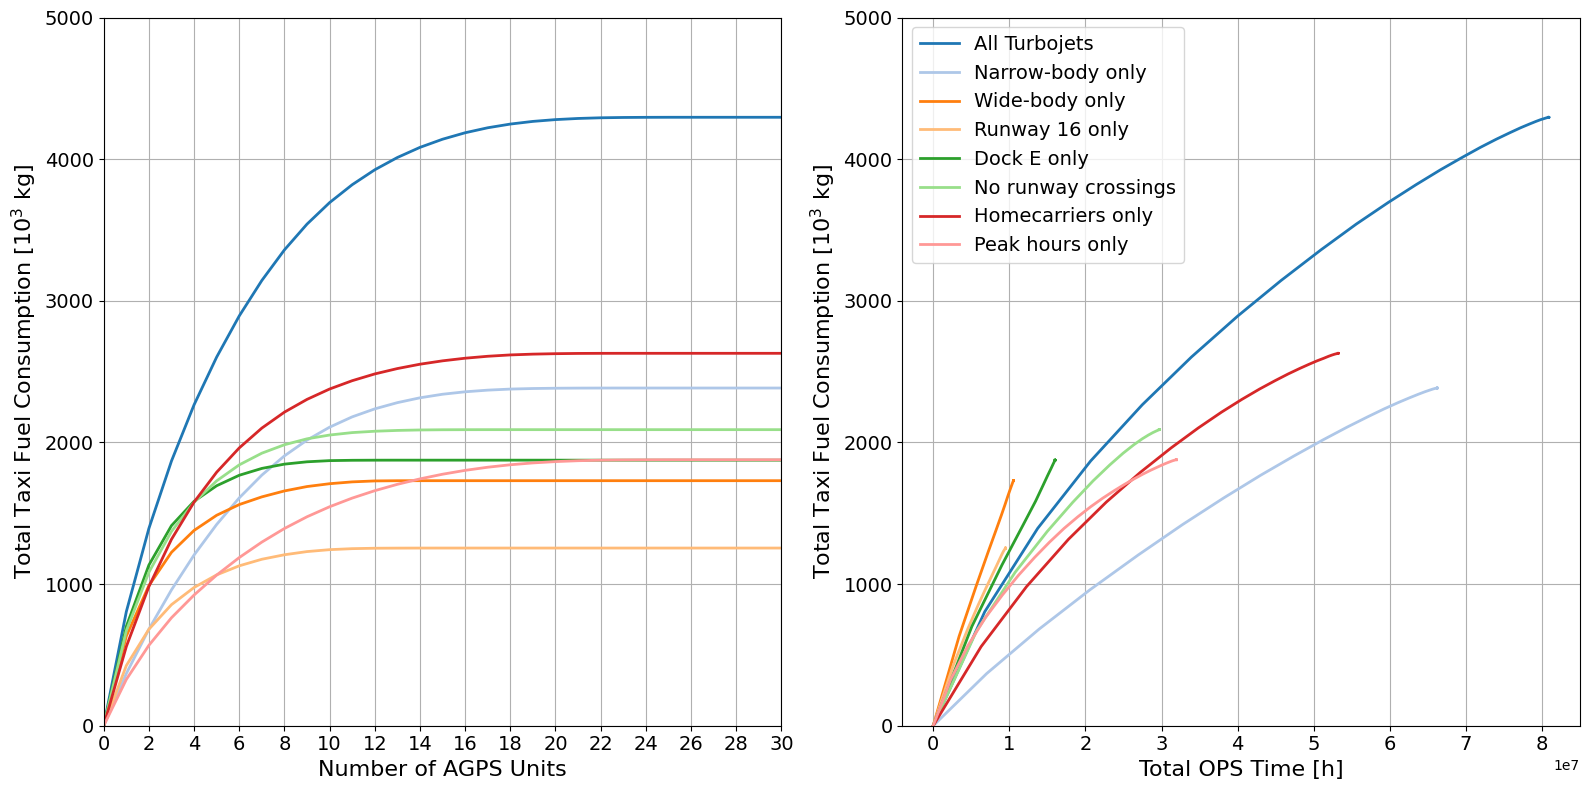

In [9]:
from matplotlib.ticker import MultipleLocator


addOSN24_data = False

config_names= df_results['config_name'].unique()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

baseline = df_results.query('config_name == @config_names[0]').baseline_fuel.iloc[0]



######## LEFT PLOT: Total Taxi Fuel Consumption per Policy #########
#axs[0].axhline(y=baseline, color='r', linestyle='-', linewidth=2.5, label='Baseline')

if addOSN24_data:
        baseline_OSN24 = df_results.query('config_name == @config_names[0]').AGPS_OSN24.iloc[0]
        axs[0].axhline(y=baseline_OSN24, color='k', linestyle='-', linewidth=2.5)

        axs[0].plot(df_results.query('config_name == @config_names[0]').nTugs, 
                    baseline-df_results.query('config_name == @config_names[0]').AGPS_OSN24,
                    color= 'k',
                    linestyle='--',
                    label='AGPS, all Runways, OSN24',
                    linewidth = 2)

for i, config_name in enumerate(config_names):
        axs[0].plot(df_results.query('config_name == @config_name').nTugs, 
                (baseline - df_results.query('config_name == @config_name').AGPS_optim_fuel), 
                color = colors[i],
                label = config_name,
                linewidth = 2)

axs[0].set_xlim((min(df_results.nTugs), max(df_results.nTugs)))
axs[0].xaxis.set_major_locator(MultipleLocator(2))

# Customize the plot
axs[0].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
# axs[0].set_title('Total Taxi Fuel Consumption', fontsize=fontsize_title)
axs[0].set_xlabel('Number of AGPS Units', fontsize=fontsize_xylabels)

# Modify and display y-ticks
y_ticks = np.arange(0, 6000 * 1e3, 1000 * 1e3)  # 0, 1000*10^3, ..., 10000*10^3
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels([f"{int(y / 1e3)}" for y in y_ticks], fontsize=fontsize_ticks)  
axs[0].set_ylim(0, 5000 * 1e3)
axs[0].set_ylabel(r'Total Taxi Fuel Consumption [$10^3$ kg]', fontsize=fontsize_xylabels)

axs[0].grid(True)


# ######## RIGHT PLOT: Relative Fuel Savings [%] #########
# for i, config_name in enumerate(config_names):
#     df_cfg = df_results.query('config_name == @config_name')
    
#     relative_savings = 100 * (baseline - df_cfg['AGPS_optim_fuel']) / baseline

#     axs[1].plot(df_cfg['nTugs'],
#                 relative_savings,
#                 color=colors[i],
#                 label='AGPS ' + config_name,
#                 linewidth=2)

# # Formatting
# axs[1].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
# axs[1].set_xlim((min(df_results.nTugs), max(df_results.nTugs)))
# axs[1].xaxis.set_major_locator(MultipleLocator(2))

# # Y-axis formatting
# axs[1].set_ylim(0, 60)
# axs[1].set_yticks(np.arange(0, 61, 10))
# axs[1].set_yticklabels([f"{y}%" for y in np.arange(0, 61, 10)], fontsize=fontsize_ticks)

# # axs[1].set_title('Relative Fuel Savings Compared to Baseline', fontsize=fontsize_title)
# axs[1].set_xlabel('Number of AGPS Units', fontsize=fontsize_xylabels)
# axs[1].set_ylabel('Fuel Saved Potential [%]', fontsize=fontsize_xylabels)
# axs[1].grid(True)

######## RIGHT PLOT: Total Taxi Fuel Consumption per AGPS Movements #########
#axs[1].axhline(y=baseline, color='r', linestyle='-', linewidth=2.5, label='Baseline')

for i, config_name in enumerate(config_names):
        axs[1].plot(df_results.query('config_name == @config_name').AGPS_ops_time, 
                (baseline - df_results.query('config_name == @config_name').AGPS_optim_fuel), 
                color = colors[i],
                label = config_name,
                linewidth = 2)
        
#axs[1].set_xlim((min(df_results.AGPS_ops_time), max(df_results.AGPS_ops_time)))

# Customize the plot
axs[1].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
# axs[1].set_title('Total Taxi Fuel Consumption', fontsize=fontsize_title)
axs[1].set_xlabel('Total OPS Time [h]', fontsize=fontsize_xylabels)

# Modify and display y-ticks
y_ticks = np.arange(0, 6000 * 1e3, 1000 * 1e3)  # 0, 1000*10^3, ..., 10000*10^3
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels([f"{int(y / 1e3)}" for y in y_ticks], fontsize=fontsize_ticks)  
axs[1].set_ylim(0, 5000 * 1e3)
axs[1].set_ylabel(r'Total Taxi Fuel Consumption [$10^3$ kg]', fontsize=fontsize_xylabels)

axs[1].grid(True)
axs[1].legend(loc='upper left', fontsize=fontsize_ticks)

plt.tight_layout()
# Save the figure as a PDF
plt.savefig('figures/fuel_efficiency_frontier.pdf', format='pdf', dpi=300, bbox_inches='tight')




***
# Policy Effectiveness

**Left Plot**
* Policy is efficient if few movements yield high savings per tug. Policy is inefficient or expensive if many movements lead to low savings per tug.
* All curves are sloping downward -> Diminishing marginal returns (as more aircraft are towed, the fuel savings per AGPS unit decline).
* With increasing AGPS usage (i.e. if many units are available), the benefits per unit go down (as they are not optimally used anymore)
* **AllTypes_allCombinations**: starts high and decreases more slowly than the others. This policy is the most scalable—each additional AGPS unit still contributes substantial fuel savings, even as more flights are towed. Best overall efficiency, especially when many AGPS movements are possible.
* **Narrow-body-only** policy yields fewer high-impact opportunities for AGPS towing.
* **Dock-e-only**: Restricting AGPS to a single dock means it hits its “sweet spot” quickly, but then runs out of impactful tows. Highly efficient for a small number of movements but not scalable

Key insights:
1. Efficiency vs. Operational Effort
* High bubbles on the left side (small movement count, high fuel saving/unit) = extremely efficient early use (e.g., dock_e_only)
* Rightward shift with shrinking bubbles = larger deployment, but diminishing per-unit returns

2. Scalable Efficiency
* Policies like allTypes_allCombinations show gradual, controlled efficiency decline across movements — these scale well.
* Policies like only_Peak_Hours show sharp efficiency drops and flatten quickly — better for targeted deployments.

3. Best ROI Zones
* Look for moderately sized bubbles that still have high Y-values. These are sweet spots where you’ve deployed a fair number of units, executed many tows, and are still getting strong fuel savings per tug.

4. Over-investment Alerts
* Bubbles low on the Y-axis, even with many movements = low marginal benefit despite high effort. e.g., if 20 tugs are deployed but you’re saving only 100k kg/unit, it may not be worth it.


**Right Plot**
* Movement-Level Diminishing Returns: Curves that plateau early (e.g., only_Peak_Hours, dock_e_only) suggest these strategies burn through high-yield opportunities quickly. allTypes_allCombinations drops slowly, maintaining consistent marginal benefit per movement, indicating long-term operational efficiency
* Policy Effectiveness at Scale: Top-right curves = policies that still return solid fuel savings per movement even after many operations (e.g., allTypes_allCombinations). Bottom-flattened curves = policies that exhaust their potential early (e.g., homecarrier_only)


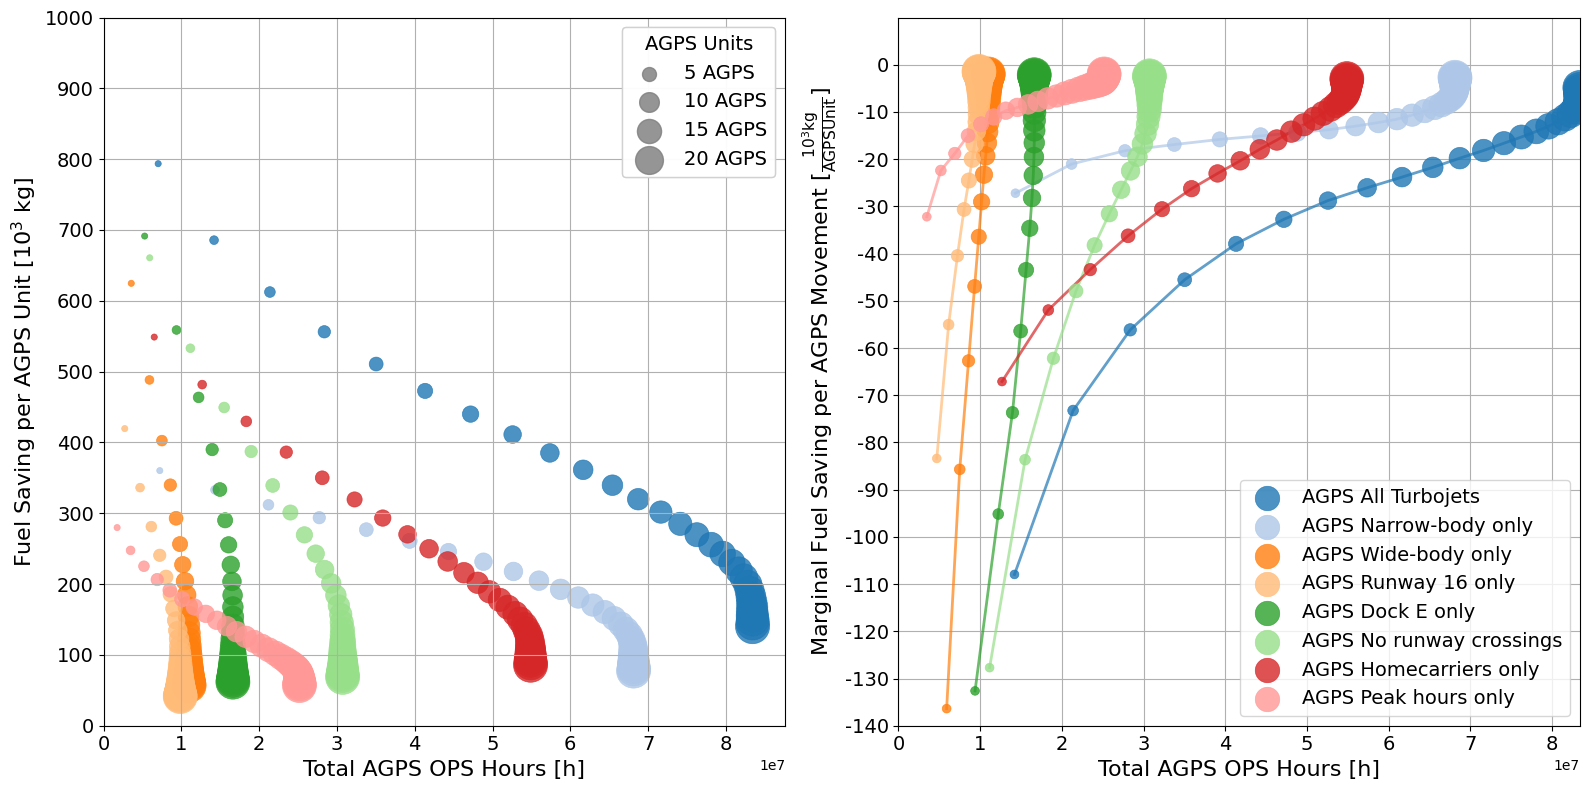

In [71]:
config_names= df_results['config_name'].unique()

baseline = df_results.query('config_name == @config_names[0]').baseline_fuel.iloc[0]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

######## Left Plot #########
# for i, config_name in enumerate(config_names):
#         axs[0].plot(df_results.query('config_name == @config_name').AGPS_optim_movements, 
#                 (baseline-df_results.query('config_name == @config_name').AGPS_optim_fuel)/df_results.query('config_name == @config_name').nTugs, 
#                 color = colors[i],
#                 label='AGPS ' + config_name,
#                 linewidth = 2)

for i, config_name in enumerate(config_names):
    df_cfg = df_results.query('config_name == @config_name')

    #x = df_cfg['AGPS_optim_movements']
    x = df_cfg['AGPS_ops_time']  # Use AGPS operation time for x-axis
    y = (baseline - df_cfg['AGPS_optim_fuel']) / df_cfg['nTugs']
    sizes = df_cfg['nTugs'] * 20  # Scale as needed

    axs[0].scatter(x, y,
                   s=sizes,  # marker size proportional to nTugs
                   color=colors[i],
                   label='AGPS ' + config_name,
                   alpha=0.8,
                #    edgecolors='w',
                   linewidth=0.5)
    

# Add a marker size scale for `nTugs`
# Choose a few representative sizes to show
example_nTugs = [5, 10, 15, 20]
handles = [axs[0].scatter([], [], s=n * 20, color='gray', alpha=0.8, label=f'{n} AGPS') for n in example_nTugs]
legend1 = axs[0].legend(handles=handles, title="AGPS Units", loc='upper right', fontsize=fontsize_ticks, title_fontsize=fontsize_ticks)
axs[0].add_artist(legend1)  # Add the marker size legend separately

# Customize the plot
axs[0].set_xlim((min(df_results.AGPS_ops_time), 1.05 * max(df_results.AGPS_ops_time)))
axs[0].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
axs[0].set_xlabel('Total AGPS OPS Hours [h]', fontsize=fontsize_xylabels)

# Modify and display y-ticks
y_ticks = np.arange(0, 1001 * 1e3, 100 * 1e3)  # 0, 1000*10^3, ..., 10000*10^3
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels([f"{int(y / 1e3)}" for y in y_ticks], fontsize=fontsize_ticks)  
axs[0].set_ylim(0, 1000 * 1e3)
axs[0].set_ylabel(r'Fuel Saving per AGPS Unit [$10^3$ kg]', fontsize=fontsize_xylabels)

#axs[0].set_title('Policy Efficiency', fontsize=fontsize_title)
axs[0].grid(True)
#axs[0].legend(loc='upper right', fontsize=fontsize_ticks)


######## Right Plot #########
delta_fuelSavings_min = 0

for i, config_name in enumerate(config_names):
    df_cfg = df_results.query('config_name == @config_name').copy()

    # Efficiency per AGPS unit (already used on left plot)
    efficiency = (baseline - df_cfg['AGPS_optim_fuel']) / df_cfg['nTugs']
    delta_efficiency = efficiency.diff().iloc[1:]  # First diff is NaN

    x = df_cfg['AGPS_ops_time'].iloc[1:]
    y = delta_efficiency
    sizes = df_cfg['nTugs'].iloc[1:] * 20  # Scale marker size as before

    # Update global min for y-tick formatting
    y_clean = y.replace([-np.inf, np.inf], np.nan).dropna()
    if not y_clean.empty and y_clean.min() < delta_fuelSavings_min:
        delta_fuelSavings_min = y_clean.min()

    axs[1].plot(x, y,
            color=colors[i],
            linewidth=2,
            alpha=0.7,
            zorder=3)  # Lower z-order than scatter for visibility

    axs[1].scatter(x, y,
                   s=sizes,
                   color=colors[i],
                   alpha=0.8,
                   linewidth=0.5,
                   zorder=4,
                   label='AGPS ' + config_name)                     

axs[1].set_xlim((min(df_results.AGPS_ops_time), max(df_results.AGPS_ops_time)))
#axs[1].xaxis.set_major_locator(MultipleLocator(2))

# Modify and display y-ticks
delta_fuelSavings_min = int(10000 * np.floor(delta_fuelSavings_min / 10000)) # round down to nearest 10000
y_ticks = np.arange(delta_fuelSavings_min, 10e3, 10 * 1e3) 
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels([f"{int(y / 1e3)}" for y in y_ticks], fontsize=fontsize_ticks)  
#axs[1].set_ylim(-110 * 1e3, 0)
axs[1].set_ylim(delta_fuelSavings_min, 10e3)


axs[1].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
#axs[1].set_title('AGPS Efficiency', fontsize=fontsize_title)
#axs[1].set_ylabel(r'$\Delta$ Fuel Saving per AGPS Unit per $\Delta$ nAGPS [$10^3$ kg]', fontsize=fontsize_xylabels)
axs[1].set_ylabel(r'Marginal Fuel Saving per AGPS Movement [$\frac{10^3\mathrm{kg}}{\mathrm{AGPS Unit}}$]', fontsize=fontsize_xylabels)
axs[1].set_xlabel('Total AGPS OPS Hours [h]', fontsize=fontsize_xylabels)
axs[1].grid(True)
axs[1].legend(loc='lower right', fontsize=fontsize_ticks)


plt.tight_layout()
# Save the figure as a PDF
plt.savefig('figures/savings_vs_opsTime.pdf', format='pdf', dpi=300, bbox_inches='tight')


**Left Plot**
* Shows how efficient each policy is in terms of total fuel saved per AGPS unit.
* We are seeing a clear diminishing return pattern: At low tug counts, savings per unit are very high. As more tugs are deployed, this metric drops, signaling lower marginal efficiency.
* Knee points: We now know how efficient each policy is when deployed to its optimal extent (e.g., allTypes_allCombinations has a knee at ~13 units and still saves ~320k kg/unit → very effective even at scale; only_Peak_Hours saturates at ~10 units and saves only ~140k kg/unit → efficient only for small-scale/time-boxed use.) → This helps you recommend not only how many units to deploy, but also which policy is worth scaling up.
* Position and height of knee points: High, early knees → High-impact with fewer units (e.g. dock_e_only, no_runway_crossings); Moderate, late knees → Requires more infrastructure but scales better (e.g. allTypes_allCombinations)W

**Right Plot**
* “How much additional fuel do I save by adding the next AGPS unit under each policy?”
* Steep negative values → high marginal fuel savings from the first few units. As the plot flattens (approaches 0), adding more AGPS units yields less benefit.
* If you have a fuel savings threshold per unit (e.g., must save at least 20,000 kg/unit to justify investment), this chart helps you visually pick the cutoff point.
* Knee points (kneedle algorithm) help identifying the ideal number of AGPS units beyond whih additional units yield significantly diminished fuel-saving returns. This is the recommended deployment size for each policy.
* Early vs. late knees: Early knees (e.g., dock_e_only) → highly efficient early on, but cannot scale. Late knees (e.g., allTypes_allCombinations) → longer-lasting gains; good for large airports or full deployment strategies.




**Policy Scalability**: 
* AGPS allTypes_allCombinations stays well above others for both metrics, meaning: It’s both efficient per unit and scalable.
* Policies like only_Peak_Hours and dock_e_only are initially efficient, but plateau quickly—they’re best suited for limited AGPS deployment.

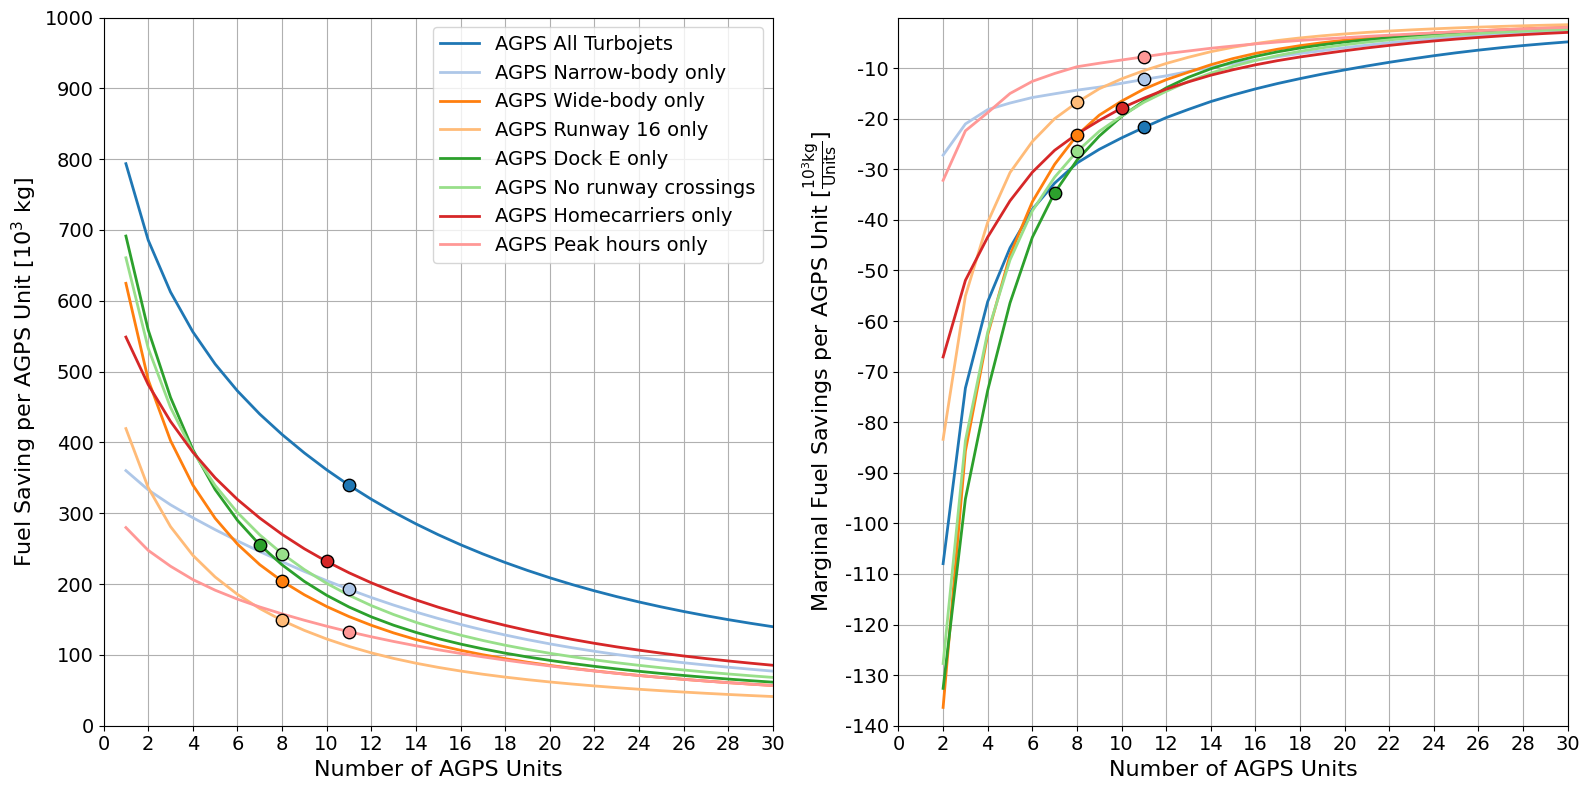

In [72]:
from kneed import KneeLocator

config_names= df_results['config_name'].unique()
baseline = df_results.query('config_name == @config_names[0]').baseline_fuel.iloc[0]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

######## Left Plot #########
# for i, config_name in enumerate(config_names):
#         axs[0].plot(df_results.query('config_name == @config_name').AGPS_optim_movements, 
#                 (baseline-df_results.query('config_name == @config_name').AGPS_optim_fuel)/df_results.query('config_name == @config_name').nTugs, 
#                 color = colors[i],
#                 label='AGPS ' + config_name,
#                 linewidth = 2)

for i, config_name in enumerate(config_names):
    df_cfg = df_results.query('config_name == @config_name')

    x = df_cfg['nTugs']
    y = (baseline - df_cfg['AGPS_optim_fuel']) / df_cfg['nTugs']

    axs[0].plot(x, 
                   y,
                   color=colors[i],
                   label='AGPS ' + config_name,
                   linewidth=2)


axs[0].set_xlim((min(df_results.nTugs), max(df_results.nTugs)))
axs[0].xaxis.set_major_locator(MultipleLocator(2))

# Customize the plot
axs[0].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
#axs[0].set_title('Policy Efficiency', fontsize=fontsize_title)
axs[0].set_xlabel('Number of AGPS Units', fontsize=fontsize_xylabels)

# Modify and display y-ticks
y_ticks = np.arange(0, 1001 * 1e3, 100 * 1e3)  # 0, 1000*10^3, ..., 10000*10^3
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels([f"{int(y / 1e3)}" for y in y_ticks], fontsize=fontsize_ticks)  
axs[0].set_ylim(0, 1000 * 1e3)
axs[0].set_ylabel(r'Fuel Saving per AGPS Unit [$10^3$ kg]', fontsize=fontsize_xylabels)

axs[0].grid(True)
axs[0].legend(loc='upper right', fontsize=fontsize_ticks)


######## Right Plot: Marginal Fuel Savings ########
saturation_points = {}
delta_fuelSavings_min = 0

for i, config_name in enumerate(config_names):
    df_config = df_results.query('config_name == @config_name and nTugs != 0')
    nTugs = df_config['nTugs'].values
    total_fuel_saved = baseline - df_config['AGPS_optim_fuel'].values

    # Apply Kneedle to cumulative fuel savings
    kneedle = KneeLocator(
        x=nTugs,
        y=total_fuel_saved,
        curve='concave',
        direction='increasing'
    )
    saturation_points[config_name] = kneedle.knee

    # Efficiency and marginal savings
    efficiency_per_unit = pd.Series(total_fuel_saved / nTugs)
    delta_fuelSavings = efficiency_per_unit.diff().iloc[1:]  # drop first NaN

    if delta_fuelSavings.replace([-np.inf, np.inf], np.nan).dropna().min() < delta_fuelSavings_min:
        delta_fuelSavings_min = delta_fuelSavings.replace([-np.inf, np.inf], np.nan).dropna().min()

    # Plot marginal savings
    axs[1].plot(df_config['nTugs'].iloc[1:],  # n-1 points
                delta_fuelSavings,
                color=colors[i],
                label='AGPS ' + config_name,
                linewidth=2)

    if kneedle.knee is not None:
        # Find the closest index to the knee (handling float imprecision)
        idx_closest = np.argmin(np.abs(df_config['nTugs'].iloc[1:] - kneedle.knee))
        x_knee = df_config['nTugs'].iloc[1 + idx_closest]  # X-coordinate (nTugs)
        y_knee_right = delta_fuelSavings.iloc[idx_closest]  # Y-value for right plot (marginal savings)

        # Plot knee on right subplot (marginal savings)
        axs[1].scatter(x_knee, y_knee_right, color=colors[i], s=80, edgecolor='black', zorder=5)

        # Now compute the Y-value for the left plot (fuel saving per unit)
        y_knee_left = ((baseline - df_config['AGPS_optim_fuel'].iloc[1 + idx_closest]) /
                    df_config['nTugs'].iloc[1 + idx_closest])

        # Plot knee on left subplot (efficiency curve)
        axs[0].scatter(x_knee, y_knee_left, color=colors[i], s=80, edgecolor='black', zorder=5)

# Format right plot
axs[1].set_xlim((min(df_results.nTugs), max(df_results.nTugs)))
axs[1].xaxis.set_major_locator(MultipleLocator(2))

delta_fuelSavings_min = int(10000 * np.floor(delta_fuelSavings_min / 10000))
y_ticks = np.arange(delta_fuelSavings_min, 0, 10 * 1e3)
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels([f"{int(y / 1e3)}" for y in y_ticks], fontsize=fontsize_ticks)
axs[1].set_ylim(delta_fuelSavings_min, 0)

axs[1].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
axs[1].set_ylabel(r'Marginal Fuel Savings per AGPS Unit [$\frac{10^3 \mathrm{kg}}{\mathrm{Units}}$]', fontsize=fontsize_xylabels)
axs[1].set_xlabel('Number of AGPS Units', fontsize=fontsize_xylabels)
axs[1].grid(True)


plt.tight_layout()
# Save the figure as a PDF
plt.savefig('figures/savings_vs_AGPSunits.pdf', format='pdf', dpi=300, bbox_inches='tight')  

/var/folders/qb/sbb3fw8j7cx9jqvndn9vkgqw0000gp/T/ipykernel_28334/3305444179.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([f"{int(t * 100)}%" for t in axs.get_xticks()])
/var/folders/qb/sbb3fw8j7cx9jqvndn9vkgqw0000gp/T/ipykernel_28334/3305444179.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels([f"{int(t * 100)}%" for t in axs.get_yticks()])


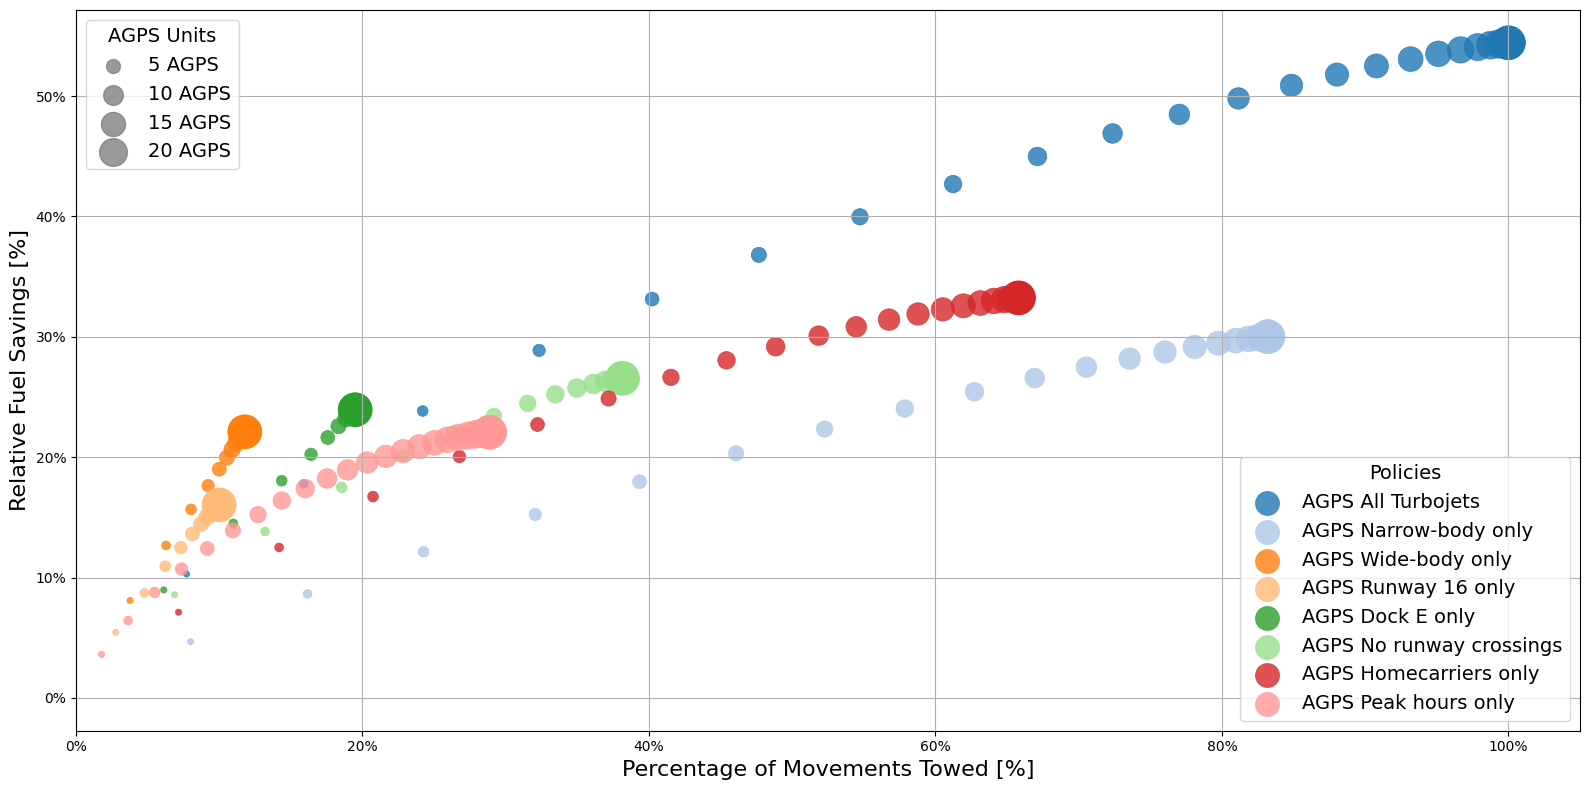

In [73]:
## Relative Savings vs. Ratio Towed/TotalMovements

config_names= df_results['config_name'].unique()

baseline = df_results.query('config_name == @config_names[0]').baseline_fuel.iloc[0]
baseline_movements = df_results.AGPS_optim_movements.max() #FIXME

# Create a figure with two subplots
# fig, axs = plt.subplots(1, 2, figsize=(16, 8))
fig, axs = plt.subplots(figsize=(16, 8))

######## Left Plot #########
# List to store only policy handles for second legend
policy_handles = []

for i, config_name in enumerate(config_names):
    df_cfg = df_results.query('config_name == @config_name')

    x = df_cfg['AGPS_optim_movements'] / baseline_movements
    y = (baseline - df_cfg['AGPS_optim_fuel']) / baseline
    sizes = df_cfg['nTugs'] * 20

    # Plot and capture handle manually
    sc = axs.scatter(x, y,
                     s=sizes,
                     color=colors[i],
                     label='AGPS ' + config_name,
                     alpha=0.8,
                     linewidth=0.5)
    policy_handles.append(sc)

# Add a marker size scale legend
example_nTugs = [5, 10, 15, 20]
size_handles = [axs.scatter([], [], s=n * 20, color='gray', alpha=0.8, label=f'{n} AGPS') for n in example_nTugs]
legend1 = axs.legend(handles=size_handles, title="AGPS Units", loc='upper left',
                     fontsize=fontsize_ticks, title_fontsize=fontsize_ticks)
axs.add_artist(legend1)

# Now manually add only the real policy entries
axs.legend(handles=policy_handles, title="Policies", loc='lower right', fontsize=fontsize_ticks, title_fontsize=fontsize_ticks)

axs.set_xlim(0, 1.05)
axs.set_xticklabels([f"{int(t * 100)}%" for t in axs.get_xticks()])
axs.set_yticklabels([f"{int(t * 100)}%" for t in axs.get_yticks()])
    
axs.set_xlabel('Percentage of Movements Towed [%]', fontsize=fontsize_xylabels)
axs.set_ylabel('Relative Fuel Savings [%]', fontsize=fontsize_xylabels)
axs.grid(True)

plt.tight_layout()
# Save the figure as a PDF
plt.savefig('figures/savings_vs_pTowed.pdf', format='pdf', dpi=300, bbox_inches='tight')


/Users/wate/Documents/GitHub/osn24_agps/.venv/lib/python3.12/site-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/wate/Documents/GitHub/osn24_agps/.venv/lib/python3.12/site-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/wate/Documents/GitHub/osn24_agps/.venv/lib/python3.12/site-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


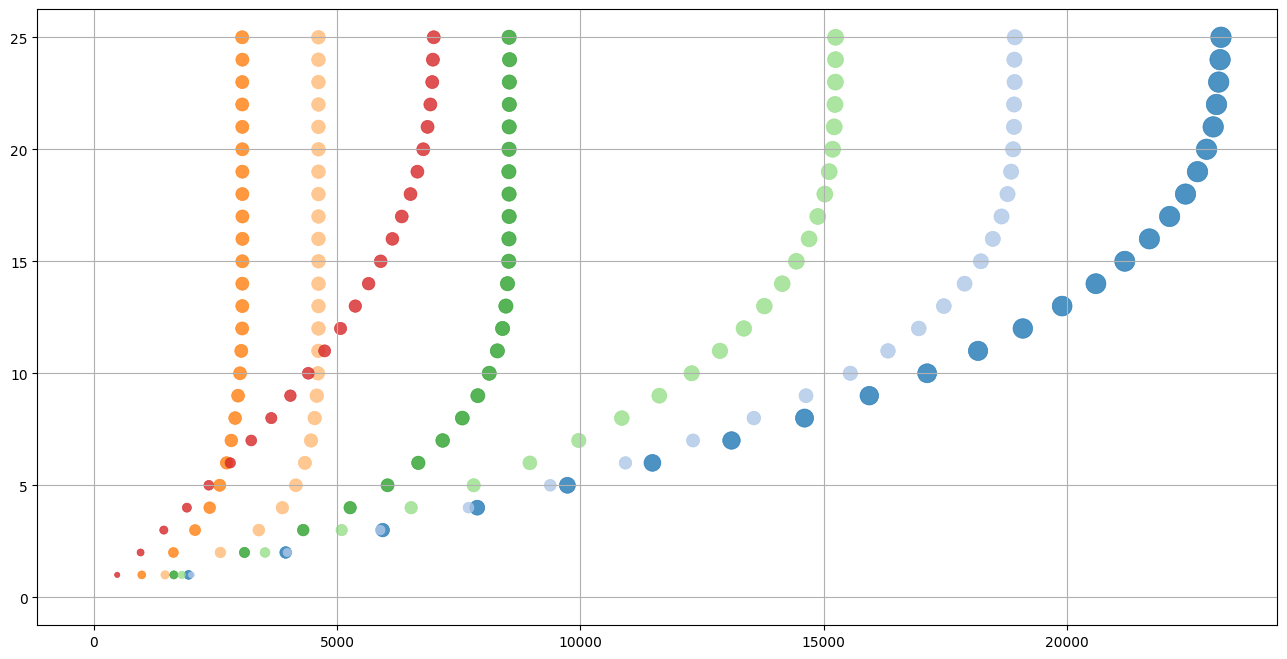

In [64]:
config_names= df_results['config_name'].unique()

baseline = df_results.query('config_name == @config_names[0]').baseline_fuel.iloc[0]

# Create a figure with two subplots
# fig, axs = plt.subplots(1, 2, figsize=(16, 8))
fig, axs = plt.subplots(figsize=(16, 8))

######## Left Plot #########
# List to store only policy handles for second legend
policy_handles = []

for i, config_name in enumerate(config_names):
    df_cfg = df_results.query('config_name == @config_name')

    x =  df_cfg['AGPS_ops_time'] / (3600)
    y = df_cfg['nTugs']
    sizes = ((baseline - df_cfg['AGPS_optim_fuel']) / baseline) * 400

    # Plot and capture handle manually
    sc = axs.scatter(x, y,
                     s=sizes,
                     color=colors[i],
                     label='AGPS ' + config_name,
                     alpha=0.8,
                     linewidth=0.5)
    policy_handles.append(sc)

axs.grid(True)

### Cost vs. Benefits

Text(0, 0.5, 'Marginal Fuel Savings [kg/AGPS Unit]')

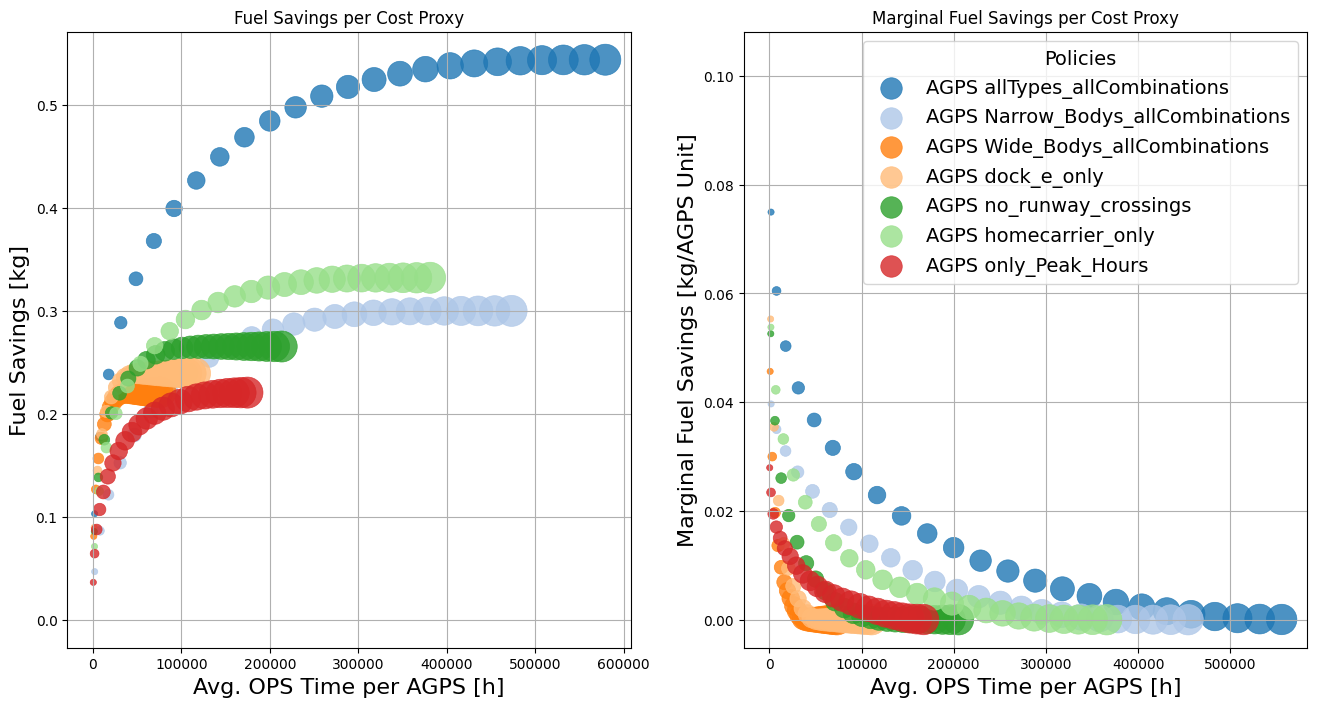

In [89]:
# x-axis: Total operating input (nTugs x average AGPS_ops_time per tug).
# y-axis: (baseline - AGPS_optim_fuel) (fuel savings)

config_names= df_results['config_name'].unique()

baseline = df_results.query('config_name == @config_names[0]').baseline_fuel.iloc[0]
baseline_movements = df_results.AGPS_optim_movements.max() #FIXME

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
#fig, axs = plt.subplots(figsize=(16, 8))

######## Left Plot #########
# List to store only policy handles for second legend
policy_handles = []

for i, config_name in enumerate(config_names):
    df_cfg = df_results.query('config_name == @config_name')

    x =  df_cfg['AGPS_ops_time'] / (3600) * df_cfg['nTugs']
    y = (baseline - df_cfg['AGPS_optim_fuel']) / baseline
    sizes = df_cfg['nTugs'] * 20

    # Plot and capture handle manually
    sc = axs[0].scatter(x, y,
                     s=sizes,
                     color=colors[i],
                     label='AGPS ' + config_name,
                     alpha=0.8,
                     linewidth=0.5)
    policy_handles.append(sc)

axs[0].grid(True)
axs[0].set_title('Fuel Savings per Cost Proxy')
axs[0].set_xlabel('Avg. OPS Time per AGPS [h]', fontsize=fontsize_xylabels)
axs[0].set_ylabel('Fuel Savings [kg]', fontsize=fontsize_xylabels)

######## Right Plot #########
# List to store only policy handles for second legend
policy_handles = []

for i, config_name in enumerate(config_names):
    df_cfg = df_results.query('config_name == @config_name')

    x =  (df_cfg['AGPS_ops_time'] / (3600)).iloc[:-1]# * df_cfg['nTugs'])
    x =  (df_cfg['AGPS_ops_time'] / (3600) * df_cfg['nTugs']).iloc[:-1]
    y = ((baseline - df_cfg['AGPS_optim_fuel'])/baseline).diff().iloc[1:]
    sizes = (df_cfg['nTugs'] * 20).iloc[:-1]

    # Plot and capture handle manually
    sc = axs[1].scatter(x, y,
                     s=sizes,
                     color=colors[i],
                     label='AGPS ' + config_name,
                     alpha=0.8,
                     linewidth=0.5)
    policy_handles.append(sc)

# Now manually add only the real policy entries
axs[1].legend(handles=policy_handles, title="Policies", loc='upper right', fontsize=fontsize_ticks, title_fontsize=fontsize_ticks)
axs[1].grid(True)
axs[1].set_title('Marginal Fuel Savings per Cost Proxy')
axs[1].set_xlabel('Avg. OPS Time per AGPS [h]', fontsize=fontsize_xylabels)
axs[1].set_ylabel('Marginal Fuel Savings [kg/AGPS Unit]', fontsize=fontsize_xylabels)


***
# Illustration of AGPS Task Assignments

In [75]:
plotdate = datetime.date(2024, 7, 10)

df = results_dict['All Turbojets'][10]

df = df[df.lineupTime.dt.date == plotdate]

# Clean & prepare
df_plot = df[df['Assigned_Tug'].notna()].copy()
df_plot['startMovement'] = pd.to_datetime(df_plot['startMovement'], errors='coerce')
df_plot['lineupTime'] = pd.to_datetime(df_plot['lineupTime'], errors='coerce')
df_plot = df_plot.dropna(subset=['startMovement', 'lineupTime', 'Assigned_Tug'])
df_plot['Assigned_Tug'] = df_plot['Assigned_Tug'].astype(int)
df_plot = df_plot.sort_values(by=['Assigned_Tug', 'startMovement'])

In [ ]:
from agps_optim import get_drive_segments


drive_segments = get_drive_segments(df_plot, distance_matrix=DISTANCE_MATRIX)



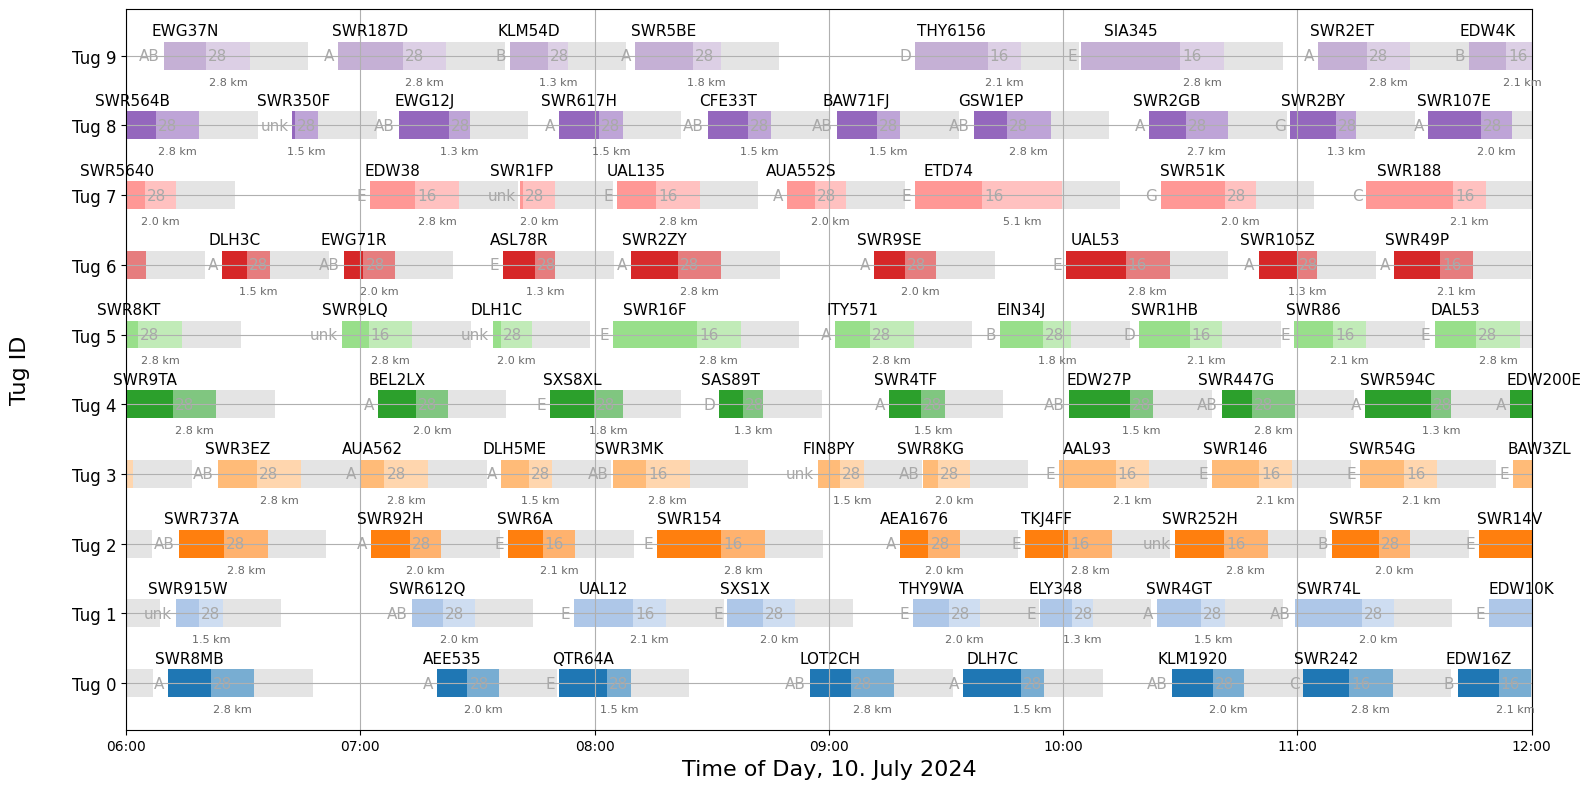

In [78]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Strip stand_area to first part before space
df_plot['stand_area_short'] = df_plot['stand_area'].astype(str).str.split().str[0]
df_plot['stand_area_short'] = df_plot['stand_area_short'].replace({'unknown': 'unk'})

# Tug positions and colors
tug_ids = sorted(df_plot['Assigned_Tug'].unique())
tug_to_y = {tug_id: i for i, tug_id in enumerate(tug_ids)}
cmap = plt.get_cmap("tab20")
colors = {tug_id: cmap(i % 20) for i, tug_id in enumerate(tug_ids)}

# Zoom range: 10:00 to 14:00
first_date = df_plot['startMovement'].dt.normalize().iloc[0]
xmin = pd.Timestamp.combine(first_date, pd.to_datetime("06:00").time())
xmax = pd.Timestamp.combine(first_date, pd.to_datetime("12:00").time())

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
plt.subplots_adjust(left=0.15, top=0.95)

for _, row in df_plot.iterrows():
    tug = row['Assigned_Tug']
    y = tug_to_y[tug]
    start = row['startMovement']
    end = row['lineupTime']
    bar_center = start + (end - start) / 2

    # Skip bars fully outside window
    if end < xmin or start > xmax:
        continue

    # Plot the bar
    ax.barh(
        y=y,
        width=end - start,
        left=start,
        height=0.4,
        color=colors[tug],
        align='center'
    )

    # Annotate callsign above the bar
    ax.text(
        x=bar_center,
        y=y + 0.25,
        s=row['callsign'],
        ha='center',
        va='bottom',
        fontsize=11,
        color='black'
    )

    # Only show stand_area if left edge is within view
    stand_x = start - pd.Timedelta(minutes=1)
    if stand_x >= xmin:
        ax.text(
            x=stand_x,
            y=y,
            s=row['stand_area_short'],
            ha='right',
            va='center',
            fontsize=11,
            color='darkgray'
        )

    # Only show runway if right edge is within view
    runway_x = end + pd.Timedelta(minutes=0.5)
    if runway_x <= xmax:
        ax.text(
            x=runway_x,
            y=y,
            s=str(row['takeoffRunway']),
            ha='left',
            va='center',
            fontsize=11,
            color='darkgray'
        )

for seg in drive_segments:
    tug_color = colors[seg['tug']]  # same color as used for the flight bar

    ax.barh(
        y=seg['y'],
        width=seg['end'] - seg['start'],
        left=seg['start'],
        height=0.4,
        color=tug_color,
        alpha=0.6,
        edgecolor='none',  # optionally remove edge to soften the effect
        align='center'
    )

    # Optional: annotate driving distance only if label is within zoom window
    label_x = seg['start'] + (seg['end'] - seg['start']) / 2
    if xmin <= label_x <= xmax:
        ax.text(
            x=label_x,
            y=seg['y'] - 0.3,
            s=f"{seg['distance']:.1f} km",
            ha='center',
            va='top',
            fontsize=8,
            color='dimgray'
        )


for seg in drive_segments:
    buffer_start = seg['end']
    buffer_end = buffer_start + buffer_time

    # Draw the buffer segment (light gray)
    ax.barh(
        y=seg['y'],
        width=buffer_end - buffer_start,
        left=buffer_start,
        height=0.4,
        color='lightgray',
        alpha=0.6,
        edgecolor='none',
        align='center'
    )

# Format axes
ax.set_yticks(list(tug_to_y.values()))
ax.set_yticklabels([f"Tug {tid}" for tid in tug_to_y.keys()], fontsize=12)
ax.set_xlabel(f"Time of Day, {plotdate.strftime("%-d. %B %Y")}", fontsize=fontsize_xylabels)
ax.set_ylabel("Tug ID", labelpad=30, fontsize=fontsize_xylabels)
#ax.set_title("Tug Usage with Stand Area and Runway Annotations")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(xmin, xmax)
#ax.set_ylim(-0.5, len(tug_to_y) - 0.5 + 1)  # leave space for top label
ax.grid(True)

plt.tight_layout()
# Save the figure as a PDF
plt.savefig('figures/tug_assignments.pdf', format='pdf', dpi=300, bbox_inches='tight')


In [ ]:
start_date = datetime.date(2024, 7, 10)
end_date = datetime.date(2024, 7, 18)

df = results_dict['allTypes_allCombinations'][15]
df = df[df.lineupTime.dt.date.between(start_date, end_date)]

df = df[df['Assigned_Tug'].notna()].copy()

df['hour'] = df['startMovement'].dt.floor('h')
df_grouped = df.groupby(['hour', 'takeoffRunway']).size().reset_index(name='tug_movements')
df_pivot = df_grouped.pivot(index='hour', columns='takeoffRunway', values='tug_movements').fillna(0)

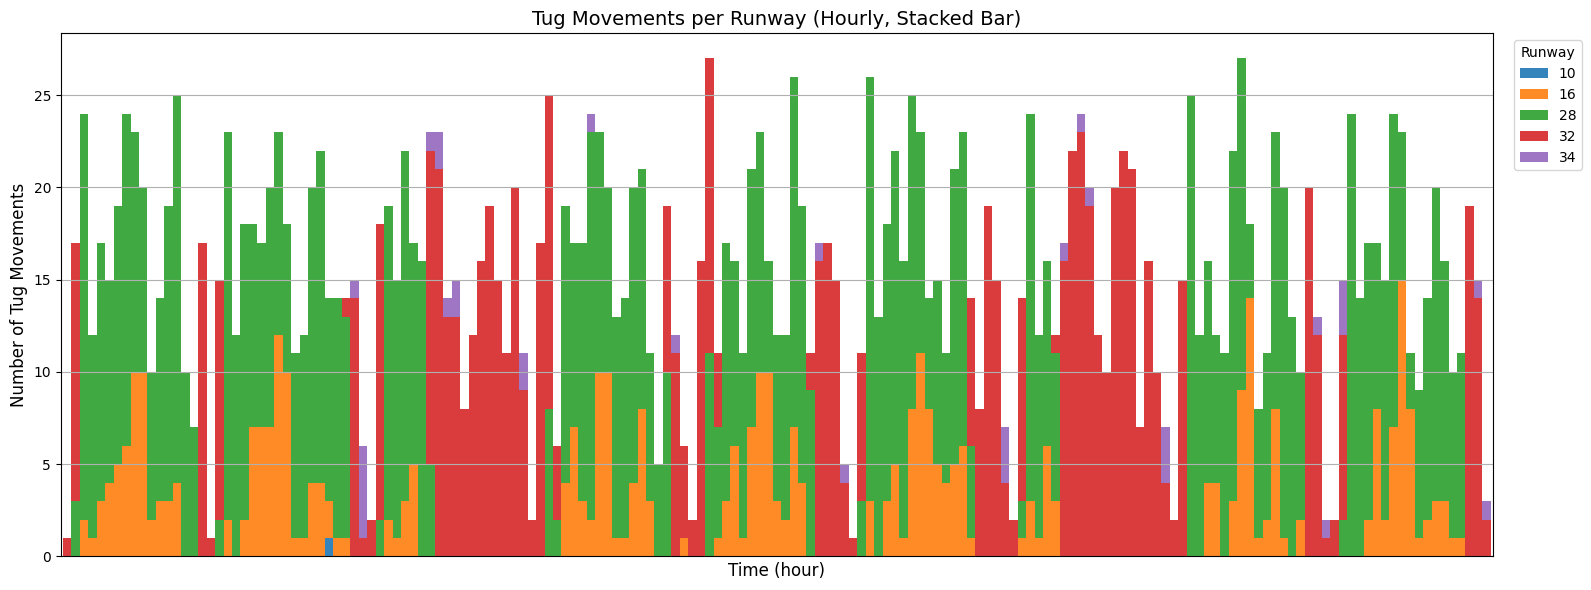

In [224]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create 6-hour spaced ticks within data range
tick_range = pd.date_range(
    start=df_pivot.index.min().floor('D'),
    end=df_pivot.index.max().ceil('D'),
    freq='6h'
)

# Keep only ticks that are in the df_pivot index
valid_ticks = tick_range.intersection(df_pivot.index)

# Match ticks to positions (in bar chart index)
xtick_positions = [df_pivot.index.get_loc(t) for t in valid_ticks]
xtick_labels = pd.to_datetime(valid_ticks).strftime('%m-%d %H:%M')

# Plot
fig, ax = plt.subplots(figsize=(16, 6))

df_pivot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=1.0,
    alpha=0.9
)

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=90)

ax.set_title("Tug Movements per Runway (Hourly, Stacked Bar)", fontsize=14)
ax.set_xlabel("Time (hour)", fontsize=12)
ax.set_ylabel("Number of Tug Movements", fontsize=12)
ax.legend(title="Runway", bbox_to_anchor=(1.01, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()

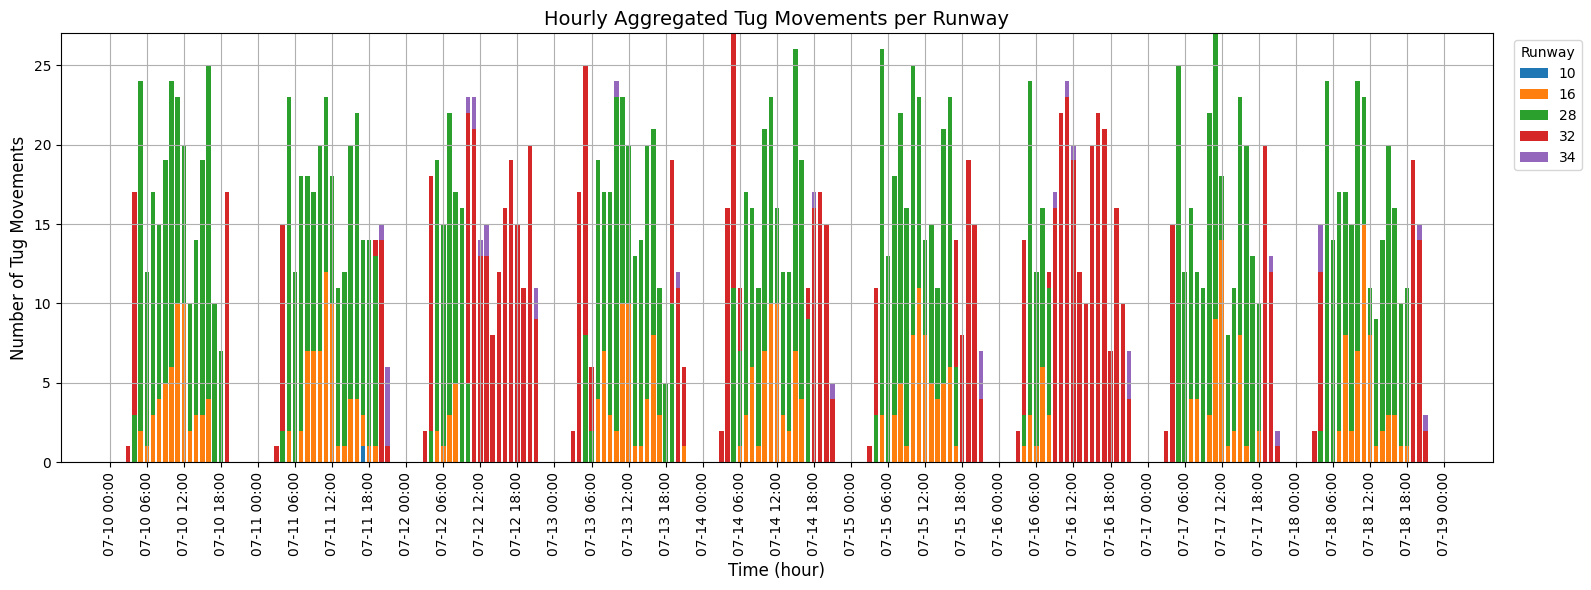

In [225]:
import matplotlib.pyplot as plt
import pandas as pd

# Reset index so 'hour' is a column
df_plot_ready = df_pivot.reset_index()

# Plot
fig, ax = plt.subplots(figsize=(16, 6))

# Plot each runway as stacked bars
bottom = pd.Series([0]*len(df_plot_ready))
for runway in df_pivot.columns:
    ax.bar(df_plot_ready['hour'], df_plot_ready[runway], bottom=bottom, label=runway, width=0.03)
    bottom += df_plot_ready[runway]

# Set x-ticks every 6 hours
tick_range = pd.date_range(
    start=df_plot_ready['hour'].min().floor('D'),
    end=df_plot_ready['hour'].max().ceil('D'),
    freq='6h'
)
ax.set_xticks(tick_range)
ax.set_xticklabels(tick_range.strftime('%m-%d %H:%M'), rotation=90)

# Labels, title, grid
ax.set_title("Hourly Aggregated Tug Movements per Runway", fontsize=14)
ax.set_xlabel("Time (hour)", fontsize=12)
ax.set_ylabel("Number of Tug Movements", fontsize=12)
ax.legend(title="Runway", bbox_to_anchor=(1.01, 1), loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()